In [1]:
import matplotlib.pyplot as plt

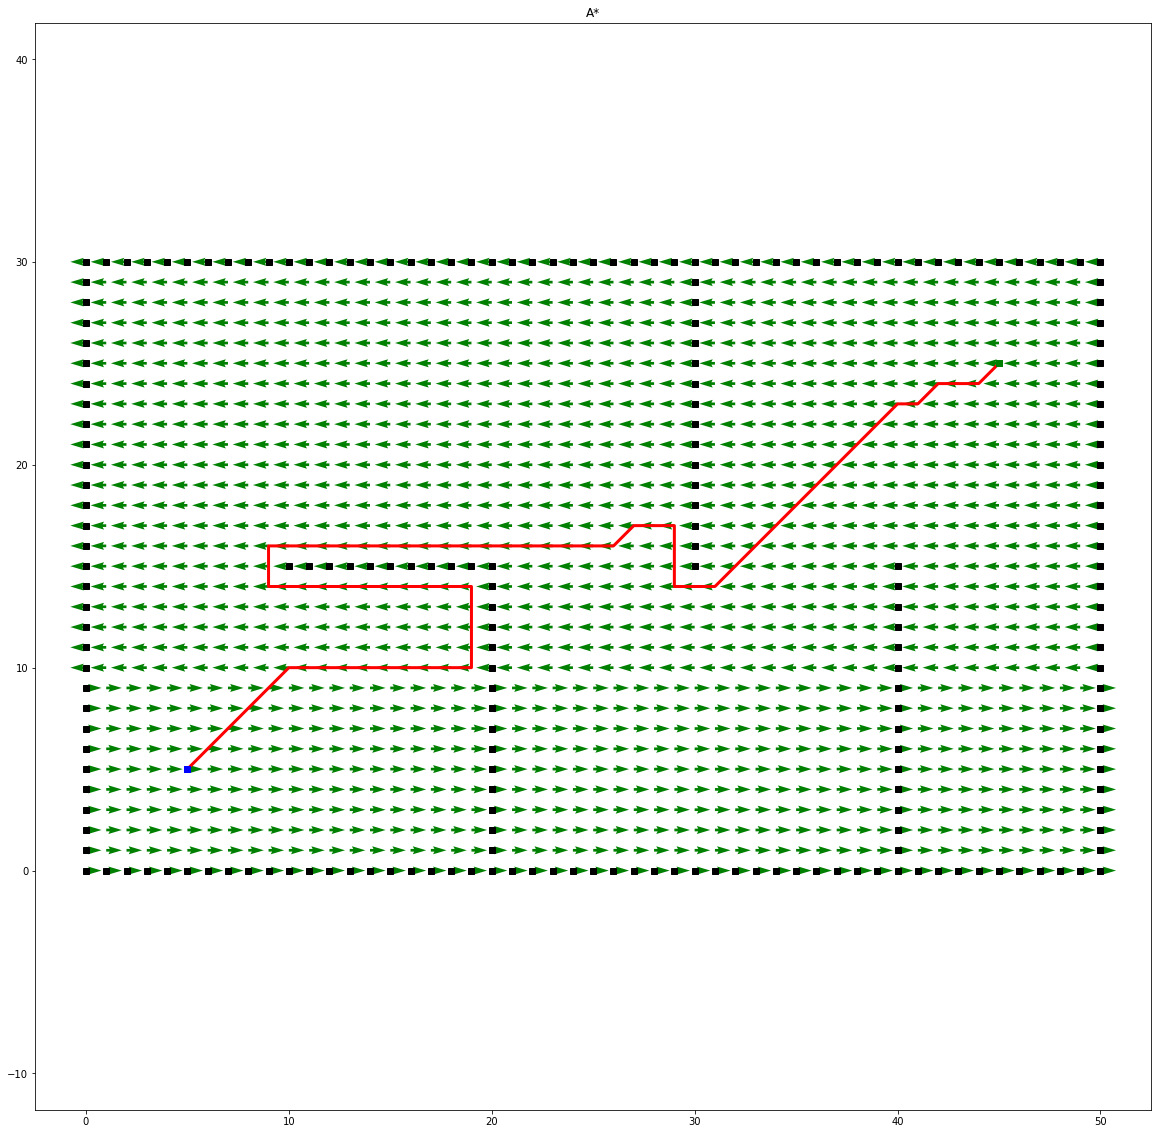

In [6]:
"""
A_star 2D
@author: huiming zhou
"""

import os
import sys
import math
import heapq
import numpy as np

sys.path.append(os.path.dirname(os.path.abspath('.')) +
                "/../../Search_based_Planning/")

from Search_2D import plotting, env

class AStar:
    """AStar set the cost + heuristics as the priority
    """
    def __init__(self, s_start, s_goal, heuristic_type):
        self.s_start = s_start
        self.s_goal = s_goal
        self.heuristic_type = heuristic_type
    
        self.Env = env.Env()  # class Env

        self.u_set = self.Env.motions  # feasible input set
        self.obs = self.Env.obs  # position of obstacles

        self.OPEN = []  # priority queue / OPEN set
        self.CLOSED = []  # CLOSED set / VISITED order
        self.PARENT = dict()  # recorded parent
        self.g = dict()  # cost to come
        
        self.wind_cost_multiplier = 1
        
        # 51 x 31
        
        self.wind_xgrid = np.concatenate( 
            (
                np.ones((10, 51)),
                -np.ones((21, 51))
            ), axis=0
        )
        self.wind_ygrid = np.zeros((31,51))

    def searching(self):
        """
        A_star Searching.
        :return: path, visited order
        """

        self.PARENT[self.s_start] = self.s_start
        self.g[self.s_start] = 0
        self.g[self.s_goal] = math.inf
        heapq.heappush(self.OPEN,
                       (self.f_value(self.s_start), self.s_start))

        while self.OPEN:
            _, s = heapq.heappop(self.OPEN)
            self.CLOSED.append(s)

            if s == self.s_goal:  # stop condition
                break

            for s_n in self.get_neighbor(s):
                new_cost = self.g[s] + self.cost(s, s_n)

                if s_n not in self.g:
                    self.g[s_n] = math.inf

                if new_cost < self.g[s_n]:  # conditions for updating Cost
                    self.g[s_n] = new_cost
                    self.PARENT[s_n] = s
                    heapq.heappush(self.OPEN, (self.f_value(s_n), s_n))

        return self.extract_path(self.PARENT), self.CLOSED

    def searching_repeated_astar(self, e):
        """
        repeated A*.
        :param e: weight of A*
        :return: path and visited order
        """

        path, visited = [], []

        while e >= 1:
            p_k, v_k = self.repeated_searching(self.s_start, self.s_goal, e)
            path.append(p_k)
            visited.append(v_k)
            e -= 0.5

        return path, visited

    def repeated_searching(self, s_start, s_goal, e):
        """
        run A* with weight e.
        :param s_start: starting state
        :param s_goal: goal state
        :param e: weight of a*
        :return: path and visited order.
        """

        g = {s_start: 0, s_goal: float("inf")}
        PARENT = {s_start: s_start}
        OPEN = []
        CLOSED = []
        heapq.heappush(OPEN,
                       (g[s_start] + e * self.heuristic(s_start), s_start))

        while OPEN:
            _, s = heapq.heappop(OPEN)
            CLOSED.append(s)

            if s == s_goal:
                break

            for s_n in self.get_neighbor(s):
                new_cost = g[s] + self.cost(s, s_n)

                if s_n not in g:
                    g[s_n] = math.inf

                if new_cos  < g[s_n]:  # conditions for updating Cost
                    g[s_n] = new_cost
                    PARENT[s_n] = s
                    heapq.heappush(OPEN, (g[s_n] + e * self.heuristic(s_n), s_n))

        return self.extract_path(PARENT), CLOSED

    def get_neighbor(self, s):
        """
        find neighbors of state s that not in obstacles.
        :param s: state
        :return: neighbors  
        """

        return [(s[0] + u[0], s[1] + u[1]) for u in self.u_set]

    def cost(self, s_start, s_goal):
        """
        Calculate Cost for this motion
        :param s_start: starting node
        :param s_goal: end node
        :return:  Cost for this motion
        :note: Cost function could be more complicate!
        """

        if self.is_collision(s_start, s_goal):
            return math.inf
        # This is just euclidean cost.
        
        x2, y2 = s_goal
        euclid_cost = math.hypot(x2 - s_start[0], y2 - s_start[1])
    
        # Just ... use final field for now? 
        # Assume start cost has been absorbed as part of prev calculation for past move already
        wind_x = self.wind_xgrid[y2][x2]
        wind_y = self.wind_ygrid[y2][x2]
        #print(self.wind_xgrid.shape, self.wind_ygrid.shape, x2, y2)
        
        wind_cost = self.wind_cost_multiplier * (wind_x + wind_y)
        return euclid_cost + wind_cost

    def is_collision(self, s_start, s_end):
        """
        check if the line segment (s_start, s_end) is collision.
        :param s_start: start node
        :param s_end: end node
        :return: True: is collision / False: not collision
        """

        if s_start in self.obs or s_end in self.obs:
            return True

        if s_start[0] != s_end[0] and s_start[1] != s_end[1]:
            if s_end[0] - s_start[0] == s_start[1] - s_end[1]:
                s1 = (min(s_start[0], s_end[0]), min(s_start[1], s_end[1]))
                s2 = (max(s_start[0], s_end[0]), max(s_start[1], s_end[1]))
            else:
                s1 = (min(s_start[0], s_end[0]), max(s_start[1], s_end[1]))
                s2 = (max(s_start[0], s_end[0]), min(s_start[1], s_end[1]))

            if s1 in self.obs or s2 in self.obs:
                return True

        return False

    def f_value(self, s):
        """
        f = g + h. (g: Cost to come, h: heuristic value)
        :param s: current state
        :return: f
        """

        return self.g[s] + self.heuristic(s)

    def extract_path(self, PARENT):
        """
        Extract the path based on the PARENT set.
        :return: The planning path
        """

        path = [self.s_goal]
        s = self.s_goal

        while True:
            s = PARENT[s]
            path.append(s)

            if s == self.s_start:
                break

        return list(path)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

    def heuristic(self, s):
        """
        Calculate heuristic.
        :param s: current node (state)
        :return: heuristic function value
        """

        heuristic_type = self.heuristic_type  # heuristic type
        goal = self.s_goal  # goal node

        if heuristic_type == "manhattan":
            return abs(goal[0] - s[0]) + abs(goal[1] - s[1])
        else:
            return math.hypot(goal[0] - s[0], goal[1] - s[1])


def main():
    s_start = (5, 5)
    s_goal = (45, 25)
    
    # map defined in Search_2D/env.py
    astar = AStar(s_start, s_goal, "euclidean")
    plot = plotting.Plotting(s_start, s_goal)

    path, visited = astar.searching()
    plot.plot_grid('A*')
    plot.plot_wind(astar.wind_xgrid, astar.wind_ygrid)
    plot.plot_path(path)
    #plot.animation(path, visited, "A*")  # animation
    # path, visited = astar.searching_repeated_astar(2.5)               # initial weight e = 2.5
    # plot.animation_ara_star(path, visited, "Repeated A*")
    plt.rcParams['figure.figsize'] = (20, 20)


if __name__ == '__main__':
    main()

In [5]:
X, Y = np.meshgrid(51,31)
print(X)

[[51]]


In [6]:
np.ones((2,1))

array([[1.],
       [1.]])

In [ ]:
#importing libraries
import numpy as np
import matplotlib.pyplot as plt
#creating arrow
x_position = 0
y_position = 0
x_direction = -1
y_direction = 0
#creating the quiver plot
fig, ax = plt.subplots(figsize = (12,7))
ax.quiver(x_position, y_position, x_direction, y_direction)
ax.set_title('A Quiver Plot with an arrow')
#Displaying the plot
plt.show()

In [ ]:
dim_x = 51
dim_y = 31
X, Y = np.meshgrid(np.linspace(0, dim_x, 1),np.linspace(0, dim_y, 1))


In [ ]:
X

In [ ]:
Y

In [ ]:
np.linspace(0, dim_x-1, dim_x)

In [ ]:
np.arange(50)

In [ ]:

        wind_xgrid = np.concatenate( 
            (
                np.ones((8, 2)),
                -np.ones((8,3))
            ), axis=1
        )
        wind_ygrid = np.zeros((8,5))


In [ ]:
wind_xgrid

In [ ]:
plt.plot()
plt.quiver(wind_xgrid, wind_ygrid)
plt.rcParams['figure.figsize'] = (10, 10)